In [48]:
# Standardbibliotheken
import sys

# Drittanbieter Libs
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont
from matplotlib import font_manager
from pathlib import Path
import math

# eigene Module
sys.path.append("../src")
from utils import luminance, clustersize, getGlyph

In [49]:
# Bild -> Pixelarray
glyph_size = 20
img = Image.open("../assets/frau_mit_tasse.jpg").convert("RGB")
pixels = np.array(img)

In [50]:
# Bildhöhe und -weite auslesen
height, width = pixels.shape[:2]
print(f'Bildhöhe = {height}')
print(f'Bildbreite = {width}')

Bildhöhe = 1080
Bildbreite = 1920


In [51]:
# berechnent die Größe der Cluster, damit diese auch gleich verteilt sind und kein Rand entsteht
cluster_y, cluster_x, cluster_height, cluster_width = clustersize(
    glyph_size, height, width
)
print(f'''
Glyphengröße = {glyph_size}
Clusteranzahl in der Höhe = {cluster_y}
Clusteranzahl in der Breite = {cluster_x}
Clusterhöhe = {cluster_height}
Clusterbreite = {cluster_width}''')


Glyphengröße = 20
Clusteranzahl in der Höhe = 54
Clusteranzahl in der Breite = 96
Clusterhöhe = 20.0
Clusterbreite = 20.0


In [52]:
# malt die Linien auf dem Bild
def draw_grid(image, cluster_y, cluster_x, cluster_height, cluster_width):
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # horizontale Linien
    for i in range(1, cluster_y):
        y = int(i * cluster_height)
        draw.line([(0, y), (width, y)], fill="red", width=1)

    # vertikale Linien
    for j in range(1, cluster_x):
        x = int(j * cluster_width)
        draw.line([(x, 0), (x, height)], fill="red", width=1)

    return image

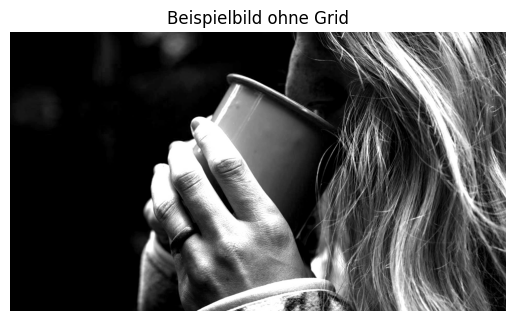

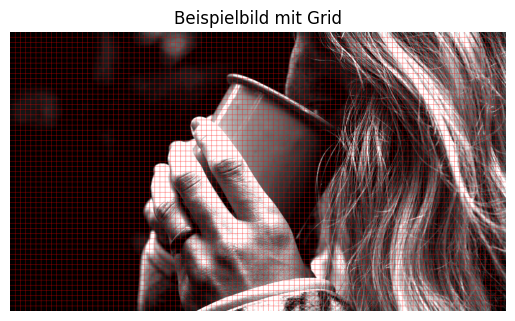

In [53]:
# zeigt das Beispielbild mit dem Grid
img_with_grid = draw_grid(img.copy(), cluster_y, cluster_x, cluster_height, cluster_width)
plt.imshow(img)
plt.title("Beispielbild ohne Grid")
plt.axis("off")
plt.show()
plt.imshow(img_with_grid)
plt.title("Beispielbild mit Grid")
plt.axis("off")
plt.show()

In [54]:
# startwert setzen, z. B. 10 pixel

cluster_y, cluster_x = int(cluster_y), int(cluster_x)
cluster_height, cluster_width = cluster_height, cluster_width

print(f"Cluster-Matrix: {cluster_y}x{cluster_x}, jede Zelle {cluster_height}x{cluster_width} Pixel")

Cluster-Matrix: 54x96, jede Zelle 20.0x20.0 Pixel


In [55]:
# 2D-Matrix für Glyphen (Liste von Listen)
glyphen_matrix = [["" for _ in range(cluster_x)] for _ in range(cluster_y)]

for i in range(cluster_y):
    for j in range(cluster_x):
        helligkeiten_added = 0.0

        # Blockbereich in Pixelkoordinaten
        row_start = i * cluster_height
        row_end   = (i + 1) * cluster_height
        col_start = j * cluster_width
        col_end   = (j + 1) * cluster_width

        # Durchschnittshelligkeit des Blocks
        
        cluster_helligkeit_durchschnitt = luminance(tuple(pixels[(int((row_start+row_end)/2)), int((col_start+col_end)/2)]))

        # Glyph bestimmen und in die Matrix schreiben
        glyph_temp = getGlyph(cluster_helligkeit_durchschnitt)
        glyphen_matrix[i][j] = glyph_temp

 2D-Matrix für Glyphen (Liste von Listen)
glyphen_matrix = [["" for _ in range(cluster_x)] for _ in range(cluster_y)]
print(f'''glyphen_matrix in Rohform:
{glyphen_matrix}
''')
print(f'range(cluster_y) = {range(cluster_y)}')
print(f'range(cluster_x) = {range(cluster_x)}')
print()

for i in range(cluster_y):
    for j in range(cluster_x):
        helligkeiten_added = 0.0

         Blockbereich in Pixelkoordinaten
        row_start = i * h
        print(f'Anfangspixel der {i}. Zeile = {row_start}')
        row_end   = (i + 1) * h
        print(f'Endpixel der {i}. Zeile = {row_end}')
        col_start = j * w
        print(f'Anfangspunkt der {j}. Spalte = {col_start}')
        col_end   = (j + 1) * w
        print(f'Endpunkt der {j}. Spalte = {col_end}')
        print()

         Helligkeiten im Block aufsummieren
        for m in range(row_start, row_end):
            for n in range(col_start, col_end):
                helligkeiten_added += luminance(tuple(pixels[m, n]))
                print(f'Helligkeiten_added = {helligkeiten_added}')

         Durchschnittshelligkeit des Blocks
        cluster_helligkeit_durchschnitt = helligkeiten_added / (h * w)
        print(f'Durchschnittliche Cluster-Helligkeit = {cluster_helligkeit_durchschnitt}')

         Glyph bestimmen und in die Matrix schreiben
        glyph_temp = getGlyph(cluster_helligkeit_durchschnitt)
        glyphen_matrix[i][j] = glyph_temp

 Optional: als Text ausgeben (erste Zeilen als Vorschau)
print("\n".join("".join(row) for row in glyphen_matrix[:40]))

In [56]:
# Schriftart auswählen

def load_monospace_font(size: int) -> ImageFont.FreeTypeFont:
    local_path = Path.cwd().parent / "assets" / "Fira_Code" / "FiraCode-VariableFont_wght.ttf"
    if local_path.exists():
        print(f"Lade lokale Schrift: {local_path}")
        return ImageFont.truetype(str(local_path), size=size)
    else:
        print("Schriftart nicht gefunden, fallback …")
        try:
            return ImageFont.truetype("DejaVuSansMono.ttf", size=size)
        except Exception:
            return ImageFont.load_default()
        
font = load_monospace_font(glyph_size-1)

Lade lokale Schrift: c:\Users\Anna\SynologyDrive\Arbeit\Freelance\glyphgen\assets\Fira_Code\FiraCode-VariableFont_wght.ttf


In [57]:
# Grid-Bild kopieren um drauf zu malen
overlay = Image.new("RGB", img_with_grid.size, color=(0, 0, 0))
draw = ImageDraw.Draw(overlay)


x0 = 0.0
y0 = 0.0
x0 = 20.0
y0 = 0.0
x0 = 40.0
y0 = 0.0
x0 = 60.0
y0 = 0.0
x0 = 80.0
y0 = 0.0
x0 = 100.0
y0 = 0.0
x0 = 120.0
y0 = 0.0
x0 = 140.0
y0 = 0.0
x0 = 160.0
y0 = 0.0
x0 = 180.0
y0 = 0.0
x0 = 200.0
y0 = 0.0
x0 = 220.0
y0 = 0.0
x0 = 240.0
y0 = 0.0
x0 = 260.0
y0 = 0.0
x0 = 280.0
y0 = 0.0
x0 = 300.0
y0 = 0.0
x0 = 320.0
y0 = 0.0
x0 = 340.0
y0 = 0.0
x0 = 360.0
y0 = 0.0
x0 = 380.0
y0 = 0.0
x0 = 400.0
y0 = 0.0
x0 = 420.0
y0 = 0.0
x0 = 440.0
y0 = 0.0
x0 = 460.0
y0 = 0.0
x0 = 480.0
y0 = 0.0
x0 = 500.0
y0 = 0.0
x0 = 520.0
y0 = 0.0
x0 = 540.0
y0 = 0.0
x0 = 560.0
y0 = 0.0
x0 = 580.0
y0 = 0.0
x0 = 600.0
y0 = 0.0
x0 = 620.0
y0 = 0.0
x0 = 640.0
y0 = 0.0
x0 = 660.0
y0 = 0.0
x0 = 680.0
y0 = 0.0
x0 = 700.0
y0 = 0.0
x0 = 720.0
y0 = 0.0
x0 = 740.0
y0 = 0.0
x0 = 760.0
y0 = 0.0
x0 = 780.0
y0 = 0.0
x0 = 800.0
y0 = 0.0
x0 = 820.0
y0 = 0.0
x0 = 840.0
y0 = 0.0
x0 = 860.0
y0 = 0.0
x0 = 880.0
y0 = 0.0
x0 = 900.0
y0 = 0.0
x0 = 920.0
y0 = 0.0
x0 = 940.0
y0 = 0.0
x0 = 960.0
y0 = 0.0
x0 = 980.0
y0 = 0.0
x0 = 1

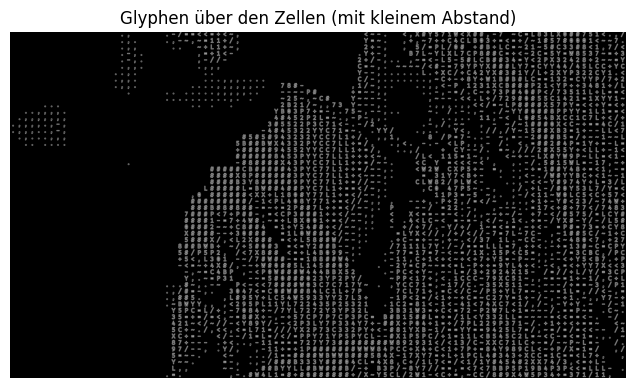

In [58]:
for i in range(cluster_y):
    for j in range(cluster_x):
        ch = glyphen_matrix[i][j] or " "

        x0, y0 = j*cluster_width, i*cluster_height
        print(f'''x0 = {x0}
y0 = {y0}''')
        x1, y1 = (j+1)*cluster_width, (i+1)*cluster_height
        cx, cy = (x0 + x1) // 2, (y0 + y1) // 2

        # Glyph ins Zentrum zeichnen
        draw.text((cx, cy), ch, font=font,
                  fill=(0, 0, 0),
                  stroke_width=1, stroke_fill=(255, 255, 255),
                  anchor="mm")

plt.figure(figsize=(8, 8 * img_with_grid.height / img_with_grid.width))
plt.imshow(overlay)
plt.axis("off")
plt.title("Glyphen über den Zellen (mit kleinem Abstand)")
plt.show()